In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

#import aparent.visualization as vis

#from aparent_predictor import *


Using TensorFlow backend.


In [2]:
#Store variant prediction dataframe

variant_df = pd.read_csv('aparent_resnet_variant_predictions_polyadb_no_sequences_no_cutoff.csv', sep='\t')


In [3]:
#Load APADB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[((~polyadb_df['gene'].isnull()) & (polyadb_df['gene'] != 'na')) & (polyadb_df['pas'] != -1)].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 175451


In [4]:
#Process PolyaDB data

polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [5]:
#Get variant positions in hg38 coordinates

polyadb_bed_hg19 = pd.read_csv("polyadb_coordinates_utr3_hg19.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg19', 'end', 'gene', 'gene_id', 'strand'])
polyadb_bed_hg38 = pd.read_csv("polyadb_coordinates_utr3_hg38.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg38', 'end', 'gene', 'gene_id', 'strand'])

polyadb_bed_hg38 = polyadb_bed_hg38.join(polyadb_bed_hg19[['gene_id', 'pas_pos_hg19']].set_index('gene_id'), on='gene_id', how='inner').copy().reset_index(drop=True)

polyadb_bed_hg38['padb_join_id'] = polyadb_bed_hg38['chrom'] + "_" + polyadb_bed_hg38['pas_pos_hg19'].astype(str) + "_" + polyadb_bed_hg38['gene']
polyadb_df['padb_join_id'] = polyadb_df['chrom'] + "_" + polyadb_df['pas_pos'].astype(str) + "_" + polyadb_df['gene']

polyadb_df = polyadb_df.join(polyadb_bed_hg38[['padb_join_id', 'pas_pos_hg38']].set_index("padb_join_id"), on='padb_join_id', how='inner').copy().reset_index(drop=True)

polyadb_df = polyadb_df.query("site_type == '3_most_exon'")

polyadb_df = polyadb_df.drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)

variant_df = variant_df.join(polyadb_df[['gene_id', 'pas_pos', 'pas_pos_hg38', 'sitenum', 'num_sites', 'pas']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)

variant_df['var_position_hg38'] = variant_df['var_position'] - variant_df['pas_pos'] + variant_df['pas_pos_hg38']


In [6]:

variant_df_gnomad = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_gnomad_no_cutoff_shifted.csv", sep='\t')

polyadb_df = polyadb_df.drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)
variant_df_gnomad = variant_df_gnomad.join(polyadb_df[['gene_id', 'pas']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)


In [7]:

variant_df_gnomad['rel_var_position'] = -1
variant_df_gnomad.loc[variant_df_gnomad['strand'] == '+', 'rel_var_position'] = variant_df_gnomad['var_position'] - (variant_df_gnomad['pas_pos'] - 70 + 1)
variant_df_gnomad.loc[variant_df_gnomad['strand'] == '-', 'rel_var_position'] = ((variant_df_gnomad['pas_pos'] - (205 - 70)) + 205) - variant_df_gnomad['var_position']


In [8]:

variant_df['rel_var_position'] = -1
variant_df.loc[variant_df['strand'] == '+', 'rel_var_position'] = variant_df['var_position'] - (variant_df['pas_pos'] - 70 + 1)
variant_df.loc[variant_df['strand'] == '-', 'rel_var_position'] = ((variant_df['pas_pos'] - (205 - 70)) + 205) - variant_df['var_position']


In [9]:

variant_df_gnomad['alt_usage'] = 1. / (1. + 1. / ((np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gnomad['delta_logodds_0_205'])))
variant_df_gnomad['delta_usage'] = variant_df_gnomad['alt_usage'] - variant_df_gnomad['native_usage']


In [10]:

variant_df['alt_usage'] = 1. / (1. + 1. / ((np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df['delta_logodds_0_205'])))
variant_df['delta_usage'] = variant_df['alt_usage'] - variant_df['native_usage']


In [11]:

variant_df_gnomad['alt_usage_77_127'] = 1. / (1. + 1. / ((np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gnomad['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gnomad['delta_logodds_77_127'])))
variant_df_gnomad['delta_usage_77_127'] = variant_df_gnomad['alt_usage_77_127'] - variant_df_gnomad['native_usage']


In [12]:

variant_df['alt_usage_77_127'] = 1. / (1. + 1. / ((np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df['delta_logodds_77_127'])))
variant_df['delta_usage_77_127'] = variant_df['alt_usage_77_127'] - variant_df['native_usage']


In [13]:
#Load ASD cohort data

asd_df = pd.read_csv("asd_cohort_de_novos.csv", sep=',')

asd_df['Chrom'] = asd_df['Chr'].astype(str)

asd_df['join_id'] = asd_df['Chrom'] + "_" + asd_df['Pos'].astype(str) + "_" + asd_df['Alt'].astype(str)
variant_df['join_id'] = variant_df['chrom'] + "_" + variant_df['var_position_hg38'].astype(str) + "_" + variant_df['var_nucleotide'].astype(str)

asd_df = asd_df.join(variant_df.set_index("join_id"), on='join_id', how='inner').copy().reset_index(drop=True)
asd_df = asd_df.join(variant_df_gnomad[['gnomad_join_id', 'AF', 'AC', 'AN']].set_index("gnomad_join_id"), on='join_id', how='left').copy().reset_index(drop=True)


In [14]:
#Compute aggregate-level PAS statistics

singleton_agg_df = variant_df_gnomad.query("AC == 1").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

singleton_agg_df.columns = ['_'.join(col).strip() + "_singleton" for col in singleton_agg_df.columns.values]

af_0_0001_agg_df = variant_df_gnomad.query("(AC > 1) and AF >= 0.0001").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

af_0_0001_agg_df.columns = ['_'.join(col).strip() + "_0_0001" for col in af_0_0001_agg_df.columns.values]

af_0_001_agg_df = variant_df_gnomad.query("(AC > 1) and AF >= 0.001").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

af_0_001_agg_df.columns = ['_'.join(col).strip() + "_0_001" for col in af_0_001_agg_df.columns.values]

af_0_01_agg_df = variant_df_gnomad.query("(AC > 1) and AF >= 0.01").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

af_0_01_agg_df.columns = ['_'.join(col).strip() + "_0_01" for col in af_0_01_agg_df.columns.values]

af_0_1_agg_df = variant_df_gnomad.query("(AC > 1) and AF >= 0.1").groupby("gene_id").agg({
    "delta_logodds_77_127" : ["min", "max", "median", "count"],
    "delta_logodds_0_205" : ["min", "max", "median", "count"],
    "delta_usage_77_127" : ["min", "max", "median", "count"],
    "delta_usage" : ["min", "max", "median", "count"],
}).copy().reset_index()

af_0_1_agg_df.columns = ['_'.join(col).strip() + "_0_1" for col in af_0_1_agg_df.columns.values]

asd_df = asd_df.join(singleton_agg_df.set_index('gene_id__singleton'), on='gene_id', how='left').copy().reset_index(drop=True)
asd_df = asd_df.join(af_0_0001_agg_df.set_index('gene_id__0_0001'), on='gene_id', how='left').copy().reset_index(drop=True)
asd_df = asd_df.join(af_0_001_agg_df.set_index('gene_id__0_001'), on='gene_id', how='left').copy().reset_index(drop=True)
asd_df = asd_df.join(af_0_01_agg_df.set_index('gene_id__0_01'), on='gene_id', how='left').copy().reset_index(drop=True)
asd_df = asd_df.join(af_0_1_agg_df.set_index('gene_id__0_1'), on='gene_id', how='left').copy().reset_index(drop=True)


In [15]:

#asd_df_copy = asd_df.copy()


In [16]:

asd_df = asd_df_copy.copy()


In [17]:

#asd_df = asd_df.query("Consequence == '3_prime_UTR_variant' or Consequence == 'downstream_gene_variant' or Consequence == 'intergenic_variant'").copy()

asd_df = asd_df.loc[asd_df['Consequence'].isin([
    '3_prime_UTR_variant',
    'intron_variant&non_coding_transcript_variant',
    'non_coding_transcript_exon_variant',
])].copy()


In [18]:

asd_df['pas'] = -1. * asd_df['pas']
asd_df['abs_delta_usage'] = np.abs(asd_df['delta_usage'])
asd_df = asd_df.sort_values(by=["pas", 'abs_delta_usage'], ascending=False).drop_duplicates(subset=['join_id', 'gene'], keep='first').copy().reset_index(drop=True)


Wilcoxon statistic = -2.0305
P-value = 0.042309109371327196
n1 / n2 = 293 / 297


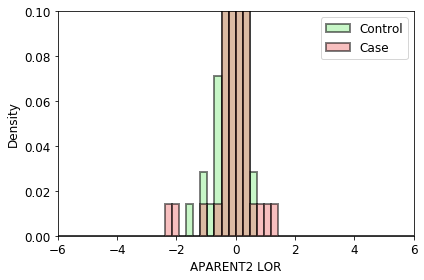

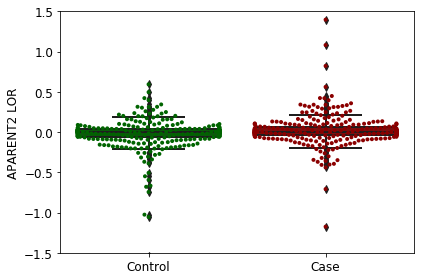

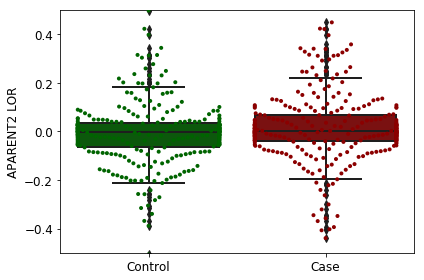

In [19]:
from scipy.stats import ttest_ind, ranksums

#Analysis 1: No filtering (LOR predictions)

f = plt.figure(figsize=(6, 4))

x_control = asd_df.query("Pheno == 'control'")['delta_logodds_0_205']
x_case = asd_df.query("Pheno == 'case'")['delta_logodds_0_205']

x_thresh = 6.
x_min = -6.

x1 = x_control
x2 = x_case

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=50, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=50, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='Control')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Case')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT2 LOR", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_histo_no_filter.eps")
plt.savefig("apa_asd_LOR_vs_control_histo_no_filter.png", dpi=300, transparent=True)

plt.show()

import seaborn as sns

f = plt.figure(figsize=(6, 4))

sns.swarmplot(data=[
    x1,
    x2,
], s=4, palette=['darkgreen', 'darkred'])

sns.boxplot(data=[
    x1,
    x2,
], color='black', linewidth=2, palette=['darkgreen', 'darkred'])

plt.ylim(-1.5, 1.5)

plt.xticks([0, 1], ["Control", "Case"], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_boxplot_no_filter.eps")
plt.savefig("apa_asd_LOR_vs_control_boxplot_no_filter.png", dpi=300, transparent=True)

plt.show()


f = plt.figure(figsize=(6, 4))

sns.swarmplot(data=[
    x1,
    x2,
], s=4, palette=['darkgreen', 'darkred'])

sns.boxplot(data=[
    x1,
    x2,
], color='black', linewidth=2, palette=['darkgreen', 'darkred'])

plt.ylim(-0.5, 0.5)

plt.xticks([0, 1], ["Control", "Case"], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_boxplot_no_filter_zoom.eps")
plt.savefig("apa_asd_LOR_vs_control_boxplot_no_filter_zoom.png", dpi=300, transparent=True)

plt.show()


In [20]:
from scipy.stats import fisher_exact

#Exact test - Centered-on PAS upregulation

gof_pas_table = np.zeros((2, 2))

gof_pas_table[0, 0] = len(asd_df.query("Pheno == 'control' and delta_logodds_77_127 <= 0"))
gof_pas_table[0, 1] = len(asd_df.query("Pheno == 'control' and delta_logodds_77_127 > 0"))

gof_pas_table[1, 0] = len(asd_df.query("Pheno == 'case' and delta_logodds_77_127 <= 0"))
gof_pas_table[1, 1] = len(asd_df.query("Pheno == 'case' and delta_logodds_77_127 > 0"))

oddsr, p = fisher_exact(gof_pas_table, alternative='greater')

print(str(gof_pas_table))

print("odds ratio = " + str(oddsr))
print("p = " + str(p))


[[160. 133.]
 [137. 160.]]
odds ratio = 1.4049722847264146
p = 0.02395581580294864


In [21]:
from scipy.stats import fisher_exact

#Exact test - All-PAS upregulation

gof_pas_table = np.zeros((2, 2))

gof_pas_table[0, 0] = len(asd_df.query("Pheno == 'control' and delta_logodds_0_205 <= 0"))
gof_pas_table[0, 1] = len(asd_df.query("Pheno == 'control' and delta_logodds_0_205 > 0"))

gof_pas_table[1, 0] = len(asd_df.query("Pheno == 'case' and delta_logodds_0_205 <= 0"))
gof_pas_table[1, 1] = len(asd_df.query("Pheno == 'case' and delta_logodds_0_205 > 0"))

oddsr, p = fisher_exact(gof_pas_table, alternative='greater')

print(str(gof_pas_table))

print("odds ratio = " + str(oddsr))
print("p = " + str(p))


[[153. 140.]
 [146. 151.]]
odds ratio = 1.1302837573385518
p = 0.254317950024677


Wilcoxon statistic = -3.5556
P-value = 0.0003771315741986888
n1 / n2 = 178 / 177


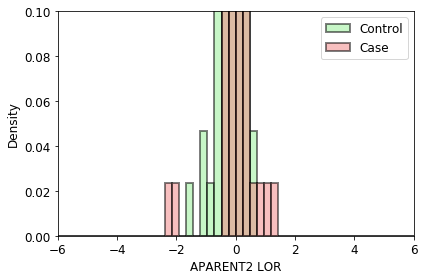

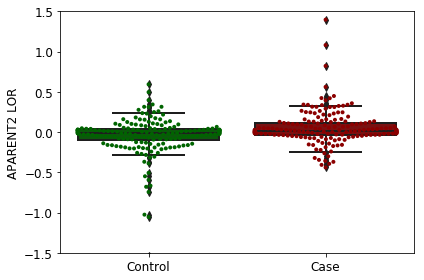

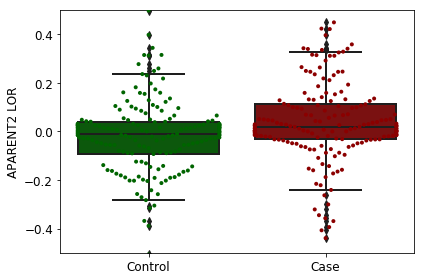

In [20]:
from scipy.stats import ttest_ind, ranksums

#Analysis 2: Filter variants with common disruptive variants within same PAS (LOR predictions)

f = plt.figure(figsize=(6, 4))

af_cutoff_str = "0_0001"

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + ") or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + "))"

x_control = asd_df.query("Pheno == 'control' and " + filter_query)['delta_logodds_0_205']
x_case = asd_df.query("Pheno == 'case' and " + filter_query)['delta_logodds_0_205']

x_thresh = 6.
x_min = -6.

x1 = x_control
x2 = x_case

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=50, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=50, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='Control')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Case')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT2 LOR", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_histo.eps")
plt.savefig("apa_asd_LOR_vs_control_histo.png", dpi=300, transparent=True)

plt.show()

import seaborn as sns

f = plt.figure(figsize=(6, 4))

sns.swarmplot(data=[
    x1,
    x2,
], s=4, palette=['darkgreen', 'darkred'])

sns.boxplot(data=[
    x1,
    x2,
], color='black', linewidth=2, palette=['darkgreen', 'darkred'])

plt.ylim(-1.5, 1.5)

plt.xticks([0, 1], ["Control", "Case"], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_boxplot.eps")
plt.savefig("apa_asd_LOR_vs_control_boxplot.png", dpi=300, transparent=True)

plt.show()


f = plt.figure(figsize=(6, 4))

sns.swarmplot(data=[
    x1,
    x2,
], s=4, palette=['darkgreen', 'darkred'])

sns.boxplot(data=[
    x1,
    x2,
], color='black', linewidth=2, palette=['darkgreen', 'darkred'])

plt.ylim(-0.5, 0.5)

plt.xticks([0, 1], ["Control", "Case"], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_boxplot_zoom.eps")
plt.savefig("apa_asd_LOR_vs_control_boxplot_zoom.png", dpi=300, transparent=True)

plt.show()


In [21]:
from scipy.stats import fisher_exact

#Exact test - Centered-on PAS upregulation

gof_pas_table = np.zeros((2, 2))

af_cutoff_str = "0_0001"

filter_query = "((delta_logodds_77_127_max_" + af_cutoff_str + " != delta_logodds_77_127_max_" + af_cutoff_str + " or delta_logodds_77_127 > delta_logodds_77_127_max_" + af_cutoff_str + ") or (delta_logodds_77_127_min_" + af_cutoff_str + " != delta_logodds_77_127_min_" + af_cutoff_str + " or delta_logodds_77_127 < delta_logodds_77_127_min_" + af_cutoff_str + "))"

gof_pas_table[0, 0] = len(asd_df.query("Pheno == 'control' and delta_logodds_77_127 <= 0 and " + filter_query))
gof_pas_table[0, 1] = len(asd_df.query("Pheno == 'control' and delta_logodds_77_127 > 0 and " + filter_query))

gof_pas_table[1, 0] = len(asd_df.query("Pheno == 'case' and delta_logodds_77_127 <= 0 and " + filter_query))
gof_pas_table[1, 1] = len(asd_df.query("Pheno == 'case' and delta_logodds_77_127 > 0 and " + filter_query))

oddsr, p = fisher_exact(gof_pas_table, alternative='greater')

print(str(gof_pas_table))

print("odds ratio = " + str(oddsr))
print("p = " + str(p))


[[105.  76.]
 [ 69. 100.]]
odds ratio = 2.002288329519451
p = 0.0009281459954981531


In [22]:
from scipy.stats import fisher_exact

#Exact test - All-PAS upregulation

gof_pas_table = np.zeros((2, 2))

af_cutoff_str = "0_0001"

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + ") or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + "))"

gof_pas_table[0, 0] = len(asd_df.query("Pheno == 'control' and delta_logodds_0_205 <= 0 and " + filter_query))
gof_pas_table[0, 1] = len(asd_df.query("Pheno == 'control' and delta_logodds_0_205 > 0 and " + filter_query))

gof_pas_table[1, 0] = len(asd_df.query("Pheno == 'case' and delta_logodds_0_205 <= 0 and " + filter_query))
gof_pas_table[1, 1] = len(asd_df.query("Pheno == 'case' and delta_logodds_0_205 > 0 and " + filter_query))

oddsr, p = fisher_exact(gof_pas_table, alternative='greater')

print(str(gof_pas_table))

print("odds ratio = " + str(oddsr))
print("p = " + str(p))


[[ 93.  85.]
 [ 70. 107.]]
odds ratio = 1.672436974789916
p = 0.010820471675569215


Wilcoxon statistic = -3.7716
P-value = 0.00016218885399817297
n1 / n2 = 178 / 175


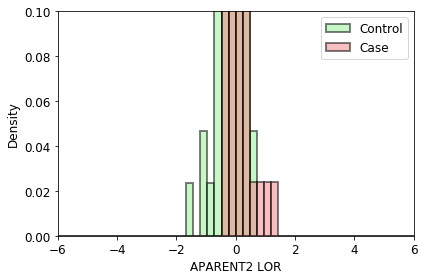

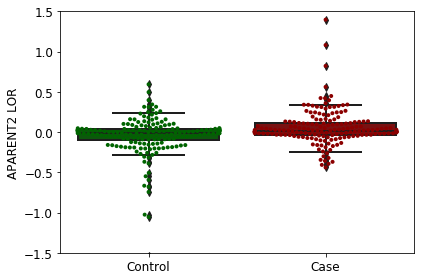

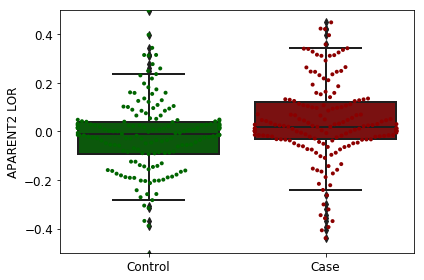

In [23]:
from scipy.stats import ttest_ind, ranksums

#Analysis 3: Filter variants with common disruptive variants within same PAS; more stringent (LOR predictions)

f = plt.figure(figsize=(6, 4))

af_cutoff_str = "0_0001"
delta_logodds_cutoff = np.abs(np.log(1.5))

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or (delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + " and delta_logodds_0_205_max_" + af_cutoff_str + " < " + str(delta_logodds_cutoff) + ")) or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or (delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + " and delta_logodds_0_205_min_" + af_cutoff_str + " > -" + str(delta_logodds_cutoff) + ")))"

x_control = asd_df.query("Pheno == 'control' and " + filter_query)['delta_logodds_0_205']
x_case = asd_df.query("Pheno == 'case' and " + filter_query)['delta_logodds_0_205']

x_thresh = 6.
x_min = -6.

x1 = x_control
x2 = x_case

s, p = ranksums(x1, x2)

print("Wilcoxon statistic = " + str(round(s, 4)))
print("P-value = " + str(p))
print("n1 / n2 = " + str(x1.shape[0]) + " / " + str(x2.shape[0]))

x1_hist, bin_edges = np.histogram(x1, range=(x_min, x_thresh), bins=50, density=True)
x2_hist, _ = np.histogram(x2, range=(x_min, x_thresh), bins=50, density=True)

bin_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_edges[:-1] + bin_width/2., x1_hist, width=bin_width, color='lightgreen', alpha=0.5, linewidth=2, edgecolor='black', label='Control')
plt.bar(bin_edges[:-1] + bin_width/2., x2_hist, width=bin_width, color='lightcoral', alpha=0.5, linewidth=2, edgecolor='black', label='Case')

plt.xlim(x_min, x_thresh)
plt.ylim(0., 0.1)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("APARENT2 LOR", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_histo_lor_cutoff.eps")
plt.savefig("apa_asd_LOR_vs_control_histo_lor_cutoff.png", dpi=300, transparent=True)

plt.show()

import seaborn as sns

f = plt.figure(figsize=(6, 4))

sns.swarmplot(data=[
    x1,
    x2,
], s=4, palette=['darkgreen', 'darkred'])

sns.boxplot(data=[
    x1,
    x2,
], color='black', linewidth=2, palette=['darkgreen', 'darkred'])

plt.ylim(-1.5, 1.5)

plt.xticks([0, 1], ["Control", "Case"], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_boxplot_cutoff.eps")
plt.savefig("apa_asd_LOR_vs_control_boxplot_cutoff.png", dpi=300, transparent=True)

plt.show()


f = plt.figure(figsize=(6, 4))

sns.swarmplot(data=[
    x1,
    x2,
], s=4, palette=['darkgreen', 'darkred'])

sns.boxplot(data=[
    x1,
    x2,
], color='black', linewidth=2, palette=['darkgreen', 'darkred'])

plt.ylim(-0.5, 0.5)

plt.xticks([0, 1], ["Control", "Case"], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("APARENT2 LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_asd_LOR_vs_control_boxplot_cutoff_zoom.eps")
plt.savefig("apa_asd_LOR_vs_control_boxplot_cutoff_zoom.png", dpi=300, transparent=True)

plt.show()


In [24]:
from scipy.stats import fisher_exact

#Exact test - Centered-on PAS upregulation

gof_pas_table = np.zeros((2, 2))

af_cutoff_str = "0_0001"
delta_logodds_cutoff = np.abs(np.log(1.5))

filter_query = "((delta_logodds_77_127_max_" + af_cutoff_str + " != delta_logodds_77_127_max_" + af_cutoff_str + " or (delta_logodds_77_127 > delta_logodds_77_127_max_" + af_cutoff_str + " and delta_logodds_77_127_max_" + af_cutoff_str + " < " + str(delta_logodds_cutoff) + ")) or (delta_logodds_77_127_min_" + af_cutoff_str + " != delta_logodds_77_127_min_" + af_cutoff_str + " or (delta_logodds_77_127 < delta_logodds_77_127_min_" + af_cutoff_str + " and delta_logodds_77_127_min_" + af_cutoff_str + " > -" + str(delta_logodds_cutoff) + ")))"

gof_pas_table[0, 0] = len(asd_df.query("Pheno == 'control' and delta_logodds_77_127 <= 0 and " + filter_query))
gof_pas_table[0, 1] = len(asd_df.query("Pheno == 'control' and delta_logodds_77_127 > 0 and " + filter_query))

gof_pas_table[1, 0] = len(asd_df.query("Pheno == 'case' and delta_logodds_77_127 <= 0 and " + filter_query))
gof_pas_table[1, 1] = len(asd_df.query("Pheno == 'case' and delta_logodds_77_127 > 0 and " + filter_query))

oddsr, p = fisher_exact(gof_pas_table, alternative='greater')

print(str(gof_pas_table))

print("odds ratio = " + str(oddsr))
print("p = " + str(p))


[[104.  76.]
 [ 67. 100.]]
odds ratio = 2.04241948153967
p = 0.0007184093055308229


In [25]:
from scipy.stats import fisher_exact

#Exact test - All-PAS upregulation

gof_pas_table = np.zeros((2, 2))

af_cutoff_str = "0_0001"
delta_logodds_cutoff = np.abs(np.log(1.5))

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or (delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + " and delta_logodds_0_205_max_" + af_cutoff_str + " < " + str(delta_logodds_cutoff) + ")) or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or (delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + " and delta_logodds_0_205_min_" + af_cutoff_str + " > -" + str(delta_logodds_cutoff) + ")))"

gof_pas_table[0, 0] = len(asd_df.query("Pheno == 'control' and delta_logodds_0_205 <= 0 and " + filter_query))
gof_pas_table[0, 1] = len(asd_df.query("Pheno == 'control' and delta_logodds_0_205 > 0 and " + filter_query))

gof_pas_table[1, 0] = len(asd_df.query("Pheno == 'case' and delta_logodds_0_205 <= 0 and " + filter_query))
gof_pas_table[1, 1] = len(asd_df.query("Pheno == 'case' and delta_logodds_0_205 > 0 and " + filter_query))

oddsr, p = fisher_exact(gof_pas_table, alternative='greater')

print(str(gof_pas_table))

print("odds ratio = " + str(oddsr))
print("p = " + str(p))


[[ 93.  85.]
 [ 68. 107.]]
odds ratio = 1.7216262975778547
p = 0.007727112871276429


In [27]:
#Create null dataframe of all gnomAD variants

null_df = variant_df_gnomad.copy()

null_df = null_df.join(singleton_agg_df.set_index('gene_id__singleton'), on='gene_id', how='left').copy().reset_index(drop=True)
null_df = null_df.join(af_0_0001_agg_df.set_index('gene_id__0_0001'), on='gene_id', how='left').copy().reset_index(drop=True)
null_df = null_df.join(af_0_001_agg_df.set_index('gene_id__0_001'), on='gene_id', how='left').copy().reset_index(drop=True)
null_df = null_df.join(af_0_01_agg_df.set_index('gene_id__0_01'), on='gene_id', how='left').copy().reset_index(drop=True)
null_df = null_df.join(af_0_1_agg_df.set_index('gene_id__0_1'), on='gene_id', how='left').copy().reset_index(drop=True)

null_df['pas'] = -1. * null_df['pas']
null_df['abs_delta_usage'] = np.abs(null_df['delta_usage'])
null_df = null_df.sort_values(by=["pas", 'abs_delta_usage'], ascending=False).drop_duplicates(subset=['gnomad_join_id', 'gene'], keep='first').copy().reset_index(drop=True)


In [32]:
#Compare null distribution to controls and cases

af_cutoff_str = "0_0001"

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + ") or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + "))"

null_df_filtered = null_df.query(filter_query).copy()
x_null_all = np.array(null_df_filtered['delta_logodds_0_205'].values)


In [33]:
#Compute statistics

from scipy.stats import ranksums, ks_2samp, epps_singleton_2samp, anderson_ksamp

wilcoxon_stat_control, wilcoxon_p_control = ranksums(x_null_all, x_control)
ks_stat_control, ks_p_control = ks_2samp(x_null_all, x_control)
es_stat_control, es_p_control = epps_singleton_2samp(x_null_all, x_control)
anderson_stat_control, _, anderson_p_control = anderson_ksamp([x_null_all, x_control])

print("--- Null vs. Control ---")
print("")
print("Wilcoxon statistic = " + str(round(wilcoxon_stat_control, 4)))
print("P-value = " + str(wilcoxon_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))
print("")
print("KS statistic = " + str(round(ks_stat_control, 4)))
print("P-value = " + str(ks_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))
print("")
print("ES statistic = " + str(round(es_stat_control, 4)))
print("P-value = " + str(es_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))
print("")
print("Anderson-Kemp statistic = " + str(round(anderson_stat_control, 4)))
print("P-value = " + str(anderson_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))

wilcoxon_stat_case, wilcoxon_p_case = ranksums(x_null_all, x_case)
ks_stat_case, ks_p_case = ks_2samp(x_null_all, x_case)
es_stat_case, es_p_case = epps_singleton_2samp(x_null_all, x_case)
anderson_stat_case, _, anderson_p_case = anderson_ksamp([x_null_all, x_case])

print("")
print("--- Null vs. Case ---")
print("")
print("Wilcoxon statistic = " + str(round(wilcoxon_stat_case, 4)))
print("P-value = " + str(wilcoxon_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))
print("")
print("KS statistic = " + str(round(ks_stat_case, 4)))
print("P-value = " + str(ks_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))
print("")
print("ES statistic = " + str(round(es_stat_case, 4)))
print("P-value = " + str(es_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))
print("")
print("Anderson-Kemp statistic = " + str(round(anderson_stat_case, 4)))
print("P-value = " + str(anderson_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: p-value capped: true value larger than 0.25


--- Null vs. Control ---

Wilcoxon statistic = 1.0073
P-value = 0.31381338016080407
n1 / n2 = 1121011 / 178

KS statistic = 0.0743
P-value = 0.26544964529182347
n1 / n2 = 1121011 / 178

ES statistic = 1.8225
P-value = 0.7683654045339481
n1 / n2 = 1121011 / 178

Anderson-Kemp statistic = 0.0329
P-value = 0.25
n1 / n2 = 1121011 / 178

--- Null vs. Case ---

Wilcoxon statistic = -4.2331
P-value = 2.3052704096381285e-05
n1 / n2 = 1121011 / 175

KS statistic = 0.1521
P-value = 0.0005348493263696296
n1 / n2 = 1121011 / 175

ES statistic = 13.5329
P-value = 0.008945192873179722
n1 / n2 = 1121011 / 175

Anderson-Kemp statistic = 10.8592
P-value = 0.001
n1 / n2 = 1121011 / 175


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:31: UserWarning: p-value floored: true value smaller than 0.001


In [34]:
#Compare null distribution to controls and cases (more stringent)

af_cutoff_str = "0_0001"
delta_logodds_cutoff = np.abs(np.log(1.5))

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or (delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + " and delta_logodds_0_205_max_" + af_cutoff_str + " < " + str(delta_logodds_cutoff) + ")) or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or (delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + " and delta_logodds_0_205_min_" + af_cutoff_str + " > -" + str(delta_logodds_cutoff) + ")))"

null_df_filtered = null_df.query(filter_query).copy()
x_null_all = np.array(null_df_filtered['delta_logodds_0_205'].values)


In [35]:
#Compute statistics

from scipy.stats import ranksums, ks_2samp, epps_singleton_2samp, anderson_ksamp

wilcoxon_stat_control, wilcoxon_p_control = ranksums(x_null_all, x_control)
ks_stat_control, ks_p_control = ks_2samp(x_null_all, x_control)
es_stat_control, es_p_control = epps_singleton_2samp(x_null_all, x_control)
anderson_stat_control, _, anderson_p_control = anderson_ksamp([x_null_all, x_control])

print("--- Null vs. Control ---")
print("")
print("Wilcoxon statistic = " + str(round(wilcoxon_stat_control, 4)))
print("P-value = " + str(wilcoxon_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))
print("")
print("KS statistic = " + str(round(ks_stat_control, 4)))
print("P-value = " + str(ks_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))
print("")
print("ES statistic = " + str(round(es_stat_control, 4)))
print("P-value = " + str(es_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))
print("")
print("Anderson-Kemp statistic = " + str(round(anderson_stat_control, 4)))
print("P-value = " + str(anderson_p_control))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_control.shape[0]))

wilcoxon_stat_case, wilcoxon_p_case = ranksums(x_null_all, x_case)
ks_stat_case, ks_p_case = ks_2samp(x_null_all, x_case)
es_stat_case, es_p_case = epps_singleton_2samp(x_null_all, x_case)
anderson_stat_case, _, anderson_p_case = anderson_ksamp([x_null_all, x_case])

print("")
print("--- Null vs. Case ---")
print("")
print("Wilcoxon statistic = " + str(round(wilcoxon_stat_case, 4)))
print("P-value = " + str(wilcoxon_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))
print("")
print("KS statistic = " + str(round(ks_stat_case, 4)))
print("P-value = " + str(ks_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))
print("")
print("ES statistic = " + str(round(es_stat_case, 4)))
print("P-value = " + str(es_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))
print("")
print("Anderson-Kemp statistic = " + str(round(anderson_stat_case, 4)))
print("P-value = " + str(anderson_p_case))
print("n1 / n2 = " + str(x_null_all.shape[0]) + " / " + str(x_case.shape[0]))


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: p-value capped: true value larger than 0.25


--- Null vs. Control ---

Wilcoxon statistic = 1.0669
P-value = 0.28601004005618025
n1 / n2 = 1115085 / 178

KS statistic = 0.0745
P-value = 0.26394733957564664
n1 / n2 = 1115085 / 178

ES statistic = 1.5739
P-value = 0.8134837685483755
n1 / n2 = 1115085 / 178

Anderson-Kemp statistic = 0.0585
P-value = 0.25
n1 / n2 = 1115085 / 178

--- Null vs. Case ---

Wilcoxon statistic = -4.1981
P-value = 2.6913334447570375e-05
n1 / n2 = 1115085 / 175

KS statistic = 0.151
P-value = 0.0006027124119156818
n1 / n2 = 1115085 / 175

ES statistic = 12.721
P-value = 0.012722388541083688
n1 / n2 = 1115085 / 175

Anderson-Kemp statistic = 10.6743
P-value = 0.001
n1 / n2 = 1115085 / 175


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:31: UserWarning: p-value floored: true value smaller than 0.001


In [110]:
#Compare to gene sets implicated in ASD

af_cutoff_str = "0_0001"
delta_logodds_cutoff = np.abs(np.log(1.5))

filter_query = "((delta_logodds_0_205_max_" + af_cutoff_str + " != delta_logodds_0_205_max_" + af_cutoff_str + " or (delta_logodds_0_205 > delta_logodds_0_205_max_" + af_cutoff_str + " and delta_logodds_0_205_max_" + af_cutoff_str + " < " + str(delta_logodds_cutoff) + ")) or (delta_logodds_0_205_min_" + af_cutoff_str + " != delta_logodds_0_205_min_" + af_cutoff_str + " or (delta_logodds_0_205 < delta_logodds_0_205_min_" + af_cutoff_str + " and delta_logodds_0_205_min_" + af_cutoff_str + " > -" + str(delta_logodds_cutoff) + ")))"

control_gene_lor_df = asd_df.query("Pheno == 'control' and " + filter_query)[['gene', 'delta_logodds_0_205']].sort_values('delta_logodds_0_205', ascending=False).drop_duplicates(subset=['gene'], keep='first')

case_gene_lor_df = asd_df.query("Pheno == 'case' and " + filter_query)[['gene', 'delta_logodds_0_205']].sort_values('delta_logodds_0_205', ascending=False).drop_duplicates(subset=['gene'], keep='first')


In [114]:

sfari_df = pd.read_csv("SFARI-Gene_genes_09-02-2021release_11-14-2021export.csv", sep=',')
sfari_df.columns = [col.replace("-", "_") for col in sfari_df.columns]


In [115]:

sfari_df.join(control_gene_lor_df.set_index("gene"), on='gene_symbol', how='inner').sort_values(by='delta_logodds_0_205')


,status,gene_symbol,gene_name,ensembl_id,chromosome,genetic_category,gene_score,syndromic,number_of_reports,delta_logodds_0_205
795,9,SDC2,"syndecan 2 (heparan sulfate proteoglycan 1, ce...",ENSG00000169439,8,"Rare Single Gene Mutation, Genetic Association",3.0,0,4,-0.54883
962,9,USP15,ubiquitin specific peptidase 15,ENSG00000135655,12,Rare Single Gene Mutation,2.0,0,3,-0.13893
566,9,NFIA,nuclear factor I/A,ENSG00000162599,1,Rare Single Gene Mutation,3.0,0,13,-0.04617
316,9,FOXP1,forkhead box P1,ENSG00000114861,3,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,1,52,-0.00167
317,9,FOXP2,forkhead box P2,ENSG00000128573,7,"Rare Single Gene Mutation, Genetic Association",1.0,0,44,0.00050
515,9,LMX1B,LIM homeobox transcription factor 1 beta,ENSG00000136944,9,Genetic Association,2.0,0,1,0.04772
335,9,FBRSL1,fibrosin like 1,ENSG00000112787,12,Syndromic,NaN,1,1,0.09580
467,9,KIAA0232,KIAA0232,ENSG00000170871,4,Rare Single Gene Mutation,1.0,0,3,0.12825
76,9,BCAS1,breast carcinoma amplified sequence 1,ENSG00000064787,20,Rare Single Gene Mutation,3.0,0,4,0.31465


In [116]:

sfari_df.join(case_gene_lor_df.set_index("gene"), on='gene_symbol', how='inner').sort_values(by='delta_logodds_0_205')


,status,gene_symbol,gene_name,ensembl_id,chromosome,genetic_category,gene_score,syndromic,number_of_reports,delta_logodds_0_205
372,9,GALNT10,polypeptide N-acetylgalactosaminyltransferase 10,ENSG00000164574,5,Genetic Association,2.0,0,5,-0.05811
553,9,NAA15,"N(alpha)-acetyltransferase 15, NatA auxiliary ...",ENSG00000164134,4,"Rare Single Gene Mutation, Syndromic",1.0,1,14,-0.04350
519,9,MED13,mediator complex subunit 13,ENSG00000108510,17,"Rare Single Gene Mutation, Syndromic",1.0,1,4,-0.00521
202,9,CNOT1,CCR4-NOT transcription complex subunit 1,ENSG00000125107,16,"Rare Single Gene Mutation, Syndromic",2.0,0,6,0.02284
873,9,STXBP5,Syntaxin binding protein 5 (tomosyn),ENSG00000164506,6,Rare Single Gene Mutation,2.0,0,6,0.04482
806,9,SF3B1,splicing factor 3b subunit 1,ENSG00000115524,2,Rare Single Gene Mutation,3.0,0,5,0.09617
931,9,TNS2,tensin 2,ENSG00000111077,12,Rare Single Gene Mutation,3.0,0,1,0.10767
648,9,PCDH9,protocadherin 9,ENSG00000184226,13,"Rare Single Gene Mutation, Genetic Association",3.0,0,7,0.32481
850,9,SNAP25,"Synaptosomal-associated protein, 25kDa",ENSG00000132639,20,"Rare Single Gene Mutation, Genetic Association",3.0,0,7,0.56204


In [131]:

szkop_neuronal_calcium_df_ellis = pd.read_csv("szkop_asd_neuronal_calcium_genes_ellis.csv", sep=',')
szkop_synaptic_df_ellis = pd.read_csv("szkop_asd_synaptic_genes_ellis.csv", sep=',')
szkop_postsynaptic_df_ellis = pd.read_csv("szkop_asd_postsynaptic_genes_ellis.csv", sep=',')

synaptic_and_postsynaptic_df = pd.read_csv("synaptic_and_postsynaptic_genes.txt", sep=',')


In [125]:

szkop_neuronal_calcium_df_ellis.join(control_gene_lor_df.set_index("gene"), on='gene', how='inner').sort_values(by='delta_logodds_0_205')


,gene,delta_logodds_0_205


In [126]:

szkop_neuronal_calcium_df_ellis.join(case_gene_lor_df.set_index("gene"), on='gene', how='inner').sort_values(by='delta_logodds_0_205')


,gene,delta_logodds_0_205
32,BRI3,0.02780
185,SNAP25,0.56204


In [127]:

szkop_synaptic_df_ellis.join(control_gene_lor_df.set_index("gene"), on='gene', how='inner').sort_values(by='delta_logodds_0_205')


,gene,delta_logodds_0_205


In [128]:

szkop_synaptic_df_ellis.join(case_gene_lor_df.set_index("gene"), on='gene', how='inner').sort_values(by='delta_logodds_0_205')


,gene,delta_logodds_0_205
15,SNAP25,0.56204


In [129]:

szkop_postsynaptic_df_ellis.join(control_gene_lor_df.set_index("gene"), on='gene', how='inner').sort_values(by='delta_logodds_0_205')


,gene,delta_logodds_0_205


In [130]:

szkop_postsynaptic_df_ellis.join(case_gene_lor_df.set_index("gene"), on='gene', how='inner').sort_values(by='delta_logodds_0_205')


,gene,delta_logodds_0_205
51,SNAP25,0.56204


In [132]:

synaptic_and_postsynaptic_df.join(control_gene_lor_df.set_index("gene"), on='gene', how='inner').sort_values(by='delta_logodds_0_205')


,gene,delta_logodds_0_205
45,AGK,-1.54508
644,HOOK3,-0.67952
15,ACAT1,-0.28316
792,MAPRE2,-0.19882
846,NCAM1,-0.15943
1405,USP15,-0.13893
164,ATP6V1D,-0.08980
1000,PLEKHA6,-0.06220
443,EEA1,-0.05610
161,ATP6V1A,-0.04952


In [133]:

synaptic_and_postsynaptic_df.join(case_gene_lor_df.set_index("gene"), on='gene', how='inner').sort_values(by='delta_logodds_0_205')


,gene,delta_logodds_0_205
33,ACTR3,-0.43947
1121,RHOB,-0.30084
454,EHD4,-0.22175
581,GNB5,-0.06462
560,GJA1,-0.03778
1412,VAPB,-0.03458
301,CMPK1,-0.02175
378,DDX17,-0.01864
356,CYTH3,0.00666
1071,PURB,0.01038


In [138]:

control_genes = sorted(control_gene_lor_df['gene'].unique().tolist())

print("\n".join(control_genes))


ACAT1
ACBD3
ADAM23
AGK
AIDA
ANP32E
ANXA5
ARFGEF3
ATP6V1A
ATP6V1D
BBIP1
BCAS1
BDNF
BNC2
BNIPL
BRD9
BTBD1
C15orf38-AP3S2
C17orf51
C21orf33
C2orf68
C7
CCDC103
CCNA2
CD7
CHD6
CHDH
CHMP5
CKAP5
CNOT6L
COCH
COX10
CPS1
CRIM1
CUEDC1
DGKI
DIDO1
DNTTIP2
DUS1L
EEA1
EIF2B2
EIF5
ERGIC1
ESCO1
EXOSC6
FAM20B
FBRSL1
FKBP5
FMN2
FOXP1
FOXP2
GCHFR
GFPT1
GNS
GPAT3
GPR83
GPRC5B
GPS1
GSTZ1
GUSB
HACE1
HDGFL3
HIPK2
HIST1H3H
HMGB2
HOOK3
HSF2BP
IL6ST
INAFM2
IRF1
IRF2BP2
JAM3
KCNK1
KIAA0232
KIAA1147
KLHDC2
KMT2D
LAYN
LIN52
LMBR1
LMX1B
LNPEP
LSM5
MAP4
MAPRE2
MAT2A
MCTP2
METTL8
MGEA5
MPP5
MRPL17
MRPL9
MTHFD2
MTMR3
MTMR9
MXD1
NCAM1
NCCRP1
NCOA7
NEU1
NFIA
NKAPD1
OPA3
ORMDL2
OXSR1
PAWR
PCDH17
PCMTD2
PKP2
PLA2G12A
PLD6
PLEKHA6
PLXNA1
PRDM11
PRRX1
PSAP
PSD2
PTBP3
PURA
PVR
QKI
RHBDL3
RNF219
RNF40
RPS23
RUNX1
SAMSN1
SAP130
SDC2
SEMA3A
SF3B3
SGMS1
SLC25A32
SLC35E3
SLC4A5
SLC9A3
SLCO3A1
SPINK13
SPOCK1
SQOR
SRPK2
ST20-MTHFS
STEAP4
STK10
STK17B
STON2
STYX
TACC2
TAGLN2
THAP11
TIMM22
TM2D2
TMEM267
TMEM53
TRAF3
TWISTNB
TWSG1
TXND

In [139]:

case_genes = sorted(case_gene_lor_df['gene'].unique().tolist())

print("\n".join(case_genes))


A1BG
AACS
ABCC10
ACTR3
ADAMTS10
AKAP10
AKIRIN1
ALDH3A2
ANAPC13
ARL2BP
B4GALT1
BAG2
BAZ1B
BCL2L11
BNIP3L
BOD1L1
BRI3
C11orf95
C8orf88
CALD1
CAMLG
CDK12
CLN5
CMPK1
CNGB1
CNOT1
COL8A1
COLCA1
CPD
CPLX2
CREG1
CTDP1
CTDSPL
CUL1
CYTH3
DCTN5
DCUN1D1
DDX17
DENND4A
DIDO1
DLK2
DPYSL5
DSCC1
EBLN3P
EHD4
EIF3H
EML1
EPM2AIP1
EPOR
ESRRG
FAM114A2
FAR1
FBXO39
GALNT10
GDF11
GJA1
GMPPB
GMPS
GNAQ
GNB5
GOLM1
GPR141
GS1-124K5
GTF2H1
HACE1
HDGFL3
HIC2
HMGB1
HMGXB4
HPGD
HPS5
HSCB
IL18BP
ITGA1
ITGA9
ITGAV
ITPRIPL1
KCNC4
KDSR
KIAA0141
KNDC1
MAN2C1
MED13
MEF2A
MEX3B
MGEA5
MICAL3
MINDY2
MLLT1
MOCS3
MRPS16
MYO6
NAA15
NAA35
NAP1L1
NEIL1
NFKBIL1
NRARP
OVOL2
PAK4
PAX2
PCDH9
PDS5B
PIGV
PLK5
PLPP3
POU3F2
PPP2R2C
PPP2R5C
PPP2R5E
PRKCE
PSEN1
PSMA2
PTPN21
PTRHD1
PURB
PYGB
RAB6B
RCOR3
REM2
RHOB
RIOK1
RNF123
RNF169
RNF44
RRP1B
RTN2
RTRAF
SAFB2
SAMD9
SAR1B
SBNO1
SECISBP2L
SF3B1
SF3B3
SKIL
SLC16A6
SLC35E3
SLC7A11
SNAP25
SOCS4
SPRED2
STK24
STRIP2
STXBP5
SYT16
TAF4
TCIM
TIAL1
TMEM106B
TMEM229B
TMPRSS11E
TNS2
TPR
TRAF3
TTC30A
TTC